In [1]:
# This is where the an4/ directory will be placed.
# Change this if you don't want the data to be extracted in the current directory.
data_dir = '.'

In [2]:
import glob
import os
import subprocess
import tarfile
import wget

# Download the dataset. This will take a few moments...
print("******")
if not os.path.exists(data_dir + '/an4_sphere.tar.gz'):
    an4_url = 'https://dldata-public.s3.us-east-2.amazonaws.com/an4_sphere.tar.gz'  # for the original source, please visit http://www.speech.cs.cmu.edu/databases/an4/an4_sphere.tar.gz 
    an4_path = wget.download(an4_url, data_dir)
    print(f"Dataset downloaded at: {an4_path}")
else:
    print("Tarfile already exists.")
    an4_path = data_dir + '/an4_sphere.tar.gz'

if not os.path.exists(data_dir + '/an4/'):
    # Untar and convert .sph to .wav (using sox)
    tar = tarfile.open(an4_path)
    tar.extractall(path=data_dir)

    print("Converting .sph to .wav...")
    sph_list = glob.glob(data_dir + '/an4/**/*.sph', recursive=True)
    for sph_path in sph_list:
        wav_path = sph_path[:-4] + '.wav'
        cmd = ["sox", sph_path, wav_path]
        subprocess.run(cmd)
print("Finished conversion.\n******")

******
Dataset downloaded at: ./an4_sphere.tar.gz
Converting .sph to .wav...
Finished conversion.
******


In [7]:
# NeMo's "core" package
import nemo
# NeMo's ASR collection - this collections contains complete ASR models and
# building blocks (modules) for ASR
import nemo.collections.asr as nemo_asr

/media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)
################################################################################
### WARNING, path does not exist: KALDI_ROOT=media/boris/F/pykaldi/kaldi
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [10]:
# --- Building Manifest Files --- #
import json

# Function to build a manifest
def build_manifest(transcripts_path, manifest_path, wav_path):
    with open(transcripts_path, 'r') as fin:
        with open(manifest_path, 'w') as fout:
            for line in fin:
                # Lines look like this:
                # <s> transcript </s> (fileID)
                transcript = line[: line.find('(')-1].lower()
                transcript = transcript.replace('<s>', '').replace('</s>', '')
                transcript = transcript.strip()

                file_id = line[line.find('(')+1 : -2]  # e.g. "cen4-fash-b"
                audio_path = os.path.join(
                    data_dir, wav_path,
                    file_id[file_id.find('-')+1 : file_id.rfind('-')],
                    file_id + '.wav')

                duration = librosa.core.get_duration(filename=audio_path)

                # Write the metadata to the manifest
                metadata = {
                    "audio_filepath": audio_path,
                    "duration": duration,
                    "text": transcript
                }
                json.dump(metadata, fout)
                fout.write('\n')
                
# Building Manifests
print("******")
train_transcripts = data_dir + '/an4/etc/an4_train.transcription'
train_manifest = data_dir + '/an4/train_manifest.json'
if not os.path.isfile(train_manifest):
    build_manifest(train_transcripts, train_manifest, 'an4/wav/an4_clstk')
    print("Training manifest created.")

test_transcripts = data_dir + '/an4/etc/an4_test.transcription'
test_manifest = data_dir + '/an4/test_manifest.json'
if not os.path.isfile(test_manifest):
    build_manifest(test_transcripts, test_manifest, 'an4/wav/an4test_clstk')
    print("Test manifest created.")
print("***Done***")

******
Training manifest created.
Test manifest created.
***Done***


In [41]:
nemo.__path__

['/media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/nemo']

In [1]:
import nemo
import nemo.collections.asr as nemo_asr
from my_model_quartznet import MyModel
import os
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import copy

from omegaconf import DictConfig

# --- Config Information ---#
try:
    from ruamel.yaml import YAML
except ModuleNotFoundError:
    from ruamel_yaml import YAML
config_path = './configs/config.yaml'

yaml = YAML(typ='safe')

/media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)
################################################################################
### WARNING, path does not exist: KALDI_ROOT=media/boris/F/pykaldi/kaldi
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-04-24 15:30:29 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [2]:
from itertools import zip_longest
from typing import Any, Callable, Dict, List, Optional

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.utilities import rank_zero_info

class PrintTableMetricsCallback(Callback):
    """Prints a table with the metrics in columns on every epoch end.
    Example::
        from pl_bolts.callbacks import PrintTableMetricsCallback
        callback = PrintTableMetricsCallback()
    Pass into trainer like so:
    .. code-block:: python
        trainer = pl.Trainer(callbacks=[callback])
        trainer.fit(...)
        # ------------------------------
        # at the end of every epoch it will print
        # ------------------------------
        # loss│train_loss│val_loss│epoch
        # ──────────────────────────────
        # 2.2541470527648926│2.2541470527648926│2.2158432006835938│0
    """

    def __init__(self) -> None:
        self.metrics: List = []

    def on_epoch_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        metrics_dict = copy.copy(trainer.callback_metrics)
        self.metrics.append(metrics_dict)
#         rank_zero_info(dicts_to_table(self.metrics))
        
def dicts_to_table(
    dicts: List[Dict],
    keys: Optional[List[str]] = None,
    pads: Optional[List[str]] = None,
    fcodes: Optional[List[str]] = None,
    convert_headers: Optional[Dict[str, Callable]] = None,
    header_names: Optional[List[str]] = None,
    skip_none_lines: bool = False,
    replace_values: Optional[Dict[str, Any]] = None,
) -> str:
    """Generate ascii table from dictionary Taken from (https://stackoverflow.com/questions/40056747/print-a-list-
    of-dictionaries-in-table-form)
    Args:
        dicts: input dictionary list; empty lists make keys OR header_names mandatory
        keys: order list of keys to generate columns for; no key/dict-key should
            suffix with '____' else adjust code-suffix
        pads: indicate padding direction and size, eg <10 to right pad alias left-align
        fcodes: formating codes for respective column type, eg .3f
        convert_headers: apply converters(dict) on column keys k, eg timestamps
        header_names: supply for custom column headers instead of keys
        skip_none_lines: skip line if contains None
        replace_values: specify per column keys k a map from seen value to new value;
                        new value must comply with the columns fcode; CAUTION: modifies input (due speed)
    Example:
        >>> a = {'a': 1, 'b': 2}
        >>> b = {'a': 3, 'b': 4}
        >>> print(dicts_to_table([a, b]))
        a│b
        ───
        1│2
        3│4
    """
    # optional arg prelude
    if keys is None:
        if len(dicts) > 0:
            keys = dicts[0].keys()  # type: ignore[assignment]
        elif header_names is not None:
            keys = header_names
        else:
            raise ValueError("keys or header_names mandatory on empty input list")
    if pads is None:
        pads = [""] * len(keys)  # type: ignore[arg-type]
    elif len(pads) != len(keys):  # type: ignore[arg-type]
        raise ValueError(f"bad pad length {len(pads)}, expected: {len(keys)}")  # type: ignore[arg-type]
    if fcodes is None:
        fcodes = [""] * len(keys)  # type: ignore[arg-type]
    elif len(fcodes) != len(fcodes):
        raise ValueError(f"bad fcodes length {len(fcodes)}, expected: {len(keys)}")  # type: ignore[arg-type]
    if convert_headers is None:
        convert_headers = {}
    if header_names is None:
        header_names = keys
    if replace_values is None:
        replace_values = {}
    # build header
    headline = "│".join(f"{v:{pad}}" for v, pad in zip_longest(header_names, pads))  # type: ignore[arg-type]
    underline = "─" * len(headline)
    # suffix special keys to apply converters to later on
    marked_keys = [h + "____" if h in convert_headers else h for h in keys]  # type: ignore[union-attr]
    marked_values = {}
    s = "│".join(f"{{{h}:{pad}{fcode}}}" for h, pad, fcode in zip_longest(marked_keys, pads, fcodes))
    lines = [headline, underline]
    for d in dicts:
        none_keys = [k for k, v in d.items() if v is None]
        if skip_none_lines and none_keys:
            continue
        elif replace_values:
            for k in d.keys():
                if k in replace_values and d[k] in replace_values[k]:
                    d[k] = replace_values[k][d[k]]
                if d[k] is None:
                    raise ValueError(f"bad or no mapping for key '{k}' is None. Use skip or change replace mapping.")
        elif none_keys:
            raise ValueError(f"keys {none_keys} are None in {d}. Do skip or use replace mapping.")
        for h in convert_headers:
            if h in keys:  # type: ignore[operator]
                converter = convert_headers[h]
                marked_values[h + "____"] = converter(d)
        line = s.format(**d, **marked_values)
        lines.append(line)
    return "\n".join(lines)

In [3]:
train_manifest = './an4/train_manifest_200.json'
test_manifest = './an4/test_manifest.json'

In [9]:
res = []

In [10]:
for corruption_prob in np.arange(0, 0.4, 0.1):
    with open(config_path) as f:
        params = yaml.load(f)
    
    callback = PrintTableMetricsCallback()
    trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=1000, callbacks=[callback])
    
    params['model']['train_ds']['manifest_filepath'] = train_manifest
    params['model']['validation_ds']['manifest_filepath'] = test_manifest
    params['model']['corruption_prob'] = float(corruption_prob)
    
    first_asr_model = MyModel(cfg=DictConfig(params['model']), trainer=trainer)
    
    trainer.fit(first_asr_model)
    df = pd.DataFrame(callback.metrics).astype(float)
    res.append(df)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


[NeMo I 2022-04-23 20:55:59 audio_to_text_dataset:41] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-04-23 20:55:59 audio_to_text_dataset:41] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-04-23 20:55:59 collections:183] Dataset loaded with 200 files totalling 0.16 hours
[NeMo I 2022-04-23 20:55:59 collections:184] 0 files were filtered totalling 0.00 hours
[NeMo I 2022-04-23 20:55:59 audio_to_text_dataset:41] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-04-23 20:55:59 audio_to_text_dataset:41] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-04-23 20:55:59 collections:183] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2022-04-23 20:55:59 collections:184] 0 files were filtered total

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[NeMo W 2022-04-23 20:55:59 modelPT:496] The lightning trainer received accelerator: <pytorch_lightning.accelerators.gpu.GPUAccelerator object at 0x7f800ceb6220>. We recommend to use 'ddp' instead.


[NeMo I 2022-04-23 20:55:59 modelPT:587] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2022-04-23 20:55:59 lr_scheduler:833] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f7fe9ef5370>" 
    will be used during training (effective maximum steps = 7000) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 7000
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 1.2 M 
2 | decoder           | ConvASRDecoder                    | 29.7 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.836     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2022-04-23 20:56:00 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo W 2022-04-23 20:56:00 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo W 2022-04-23 20:56:00 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packag

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-23 20:56:01 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/torch/nn/modules/module.py:1385: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
      warnings.warn(
    
[NeMo W 2022-04-23 20:56:01 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/torch/nn/modules/module.py:1385: UserWarning: argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
      warnings.warn(
    


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


[NeMo I 2022-04-23 21:11:03 audio_to_text_dataset:41] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-04-23 21:11:03 audio_to_text_dataset:41] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-04-23 21:11:03 collections:183] Dataset loaded with 200 files totalling 0.16 hours
[NeMo I 2022-04-23 21:11:03 collections:184] 0 files were filtered totalling 0.00 hours
[NeMo I 2022-04-23 21:11:03 audio_to_text_dataset:41] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-04-23 21:11:03 audio_to_text_dataset:41] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-04-23 21:11:03 collections:183] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2022-04-23 21:11:03 collections:184] 0 files were filtered total

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[NeMo W 2022-04-23 21:11:03 modelPT:496] The lightning trainer received accelerator: <pytorch_lightning.accelerators.gpu.GPUAccelerator object at 0x7f7fe9efbd60>. We recommend to use 'ddp' instead.


[NeMo I 2022-04-23 21:11:03 modelPT:587] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2022-04-23 21:11:03 lr_scheduler:833] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f7fcaba2760>" 
    will be used during training (effective maximum steps = 7000) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 7000
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 1.2 M 
2 | decoder           | ConvASRDecoder                    | 29.7 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.836     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2022-04-23 21:11:03 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo W 2022-04-23 21:11:03 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo W 2022-04-23 21:11:03 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packag

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-23 21:11:04 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/torch/nn/modules/module.py:1385: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
      warnings.warn(
    
[NeMo W 2022-04-23 21:11:04 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/torch/nn/modules/module.py:1385: UserWarning: argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
      warnings.warn(
    


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-23 21:23:27 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
      rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
    
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


[NeMo I 2022-04-23 21:23:27 audio_to_text_dataset:41] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-04-23 21:23:27 audio_to_text_dataset:41] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-04-23 21:23:27 collections:183] Dataset loaded with 200 files totalling 0.16 hours
[NeMo I 2022-04-23 21:23:27 collections:184] 0 files were filtered totalling 0.00 hours
[NeMo I 2022-04-23 21:23:27 audio_to_text_dataset:41] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-04-23 21:23:27 audio_to_text_dataset:41] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-04-23 21:23:27 collections:183] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2022-04-23 21:23:27 collections:184] 0 files were filtered total

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[NeMo W 2022-04-23 21:23:27 modelPT:496] The lightning trainer received accelerator: <pytorch_lightning.accelerators.gpu.GPUAccelerator object at 0x7f7fc8a8e3a0>. We recommend to use 'ddp' instead.


[NeMo I 2022-04-23 21:23:27 modelPT:587] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2022-04-23 21:23:27 lr_scheduler:833] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f7fc881f6d0>" 
    will be used during training (effective maximum steps = 7000) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 7000
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 1.2 M 
2 | decoder           | ConvASRDecoder                    | 29.7 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.836     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2022-04-23 21:23:28 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo W 2022-04-23 21:23:28 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo W 2022-04-23 21:23:28 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packag

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-23 21:23:29 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/torch/nn/modules/module.py:1385: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
      warnings.warn(
    
[NeMo W 2022-04-23 21:23:29 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/torch/nn/modules/module.py:1385: UserWarning: argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
      warnings.warn(
    


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-23 21:23:45 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
      rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
    
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


[NeMo I 2022-04-23 21:23:45 audio_to_text_dataset:41] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-04-23 21:23:45 audio_to_text_dataset:41] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-04-23 21:23:45 collections:183] Dataset loaded with 200 files totalling 0.16 hours
[NeMo I 2022-04-23 21:23:45 collections:184] 0 files were filtered totalling 0.00 hours
[NeMo I 2022-04-23 21:23:45 audio_to_text_dataset:41] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-04-23 21:23:45 audio_to_text_dataset:41] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-04-23 21:23:45 collections:183] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2022-04-23 21:23:45 collections:184] 0 files were filtered total

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[NeMo W 2022-04-23 21:23:45 modelPT:496] The lightning trainer received accelerator: <pytorch_lightning.accelerators.gpu.GPUAccelerator object at 0x7f7fc87ebdf0>. We recommend to use 'ddp' instead.


[NeMo I 2022-04-23 21:23:45 modelPT:587] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2022-04-23 21:23:45 lr_scheduler:833] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f7fc8516340>" 
    will be used during training (effective maximum steps = 7000) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 7000
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 1.2 M 
2 | decoder           | ConvASRDecoder                    | 29.7 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.836     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2022-04-23 21:23:45 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo W 2022-04-23 21:23:45 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
      rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
    


In [26]:
print(batch[0].shape, batch[1].shape, batch[2].shape, batch[3].shape)

# torch.vstack((batch[0], batch[0])).shape
torch.hstack((batch[1], batch[1])).shape
# torch.vstack((batch[2], batch[2])).shape
# torch.hstack((batch[3], batch[3])).shape


# for batch in first_asr_model.train_dataloader():
#     flipped = flip_batch(batch)
#     print(batch[2][0], '\n', flipped[2][0])
#     break

torch.Size([32, 96000]) torch.Size([32]) torch.Size([32, 38]) torch.Size([32])


torch.Size([64])

In [17]:
import torch

In [45]:
res[1][::2].reset_index()

,index,val_loss,val_wer,train_loss,learning_rate
0,0,874.025391,0.981675,NaN,NaN
1,2,796.265564,1.000000,674.110352,9.999982e-03
2,4,738.785095,1.000000,159.445816,9.999915e-03
3,6,707.441956,1.000000,111.306229,9.999799e-03
4,8,665.248474,1.000000,108.222595,9.999633e-03
...,...,...,...,...,...
996,1992,69.265320,0.705045,0.072674,4.234806e-07
997,1994,68.760429,0.690815,4.082834,2.437168e-07
998,1996,69.087975,0.690815,0.190582,1.132986e-07
999,1998,64.988754,0.694696,0.261869,3.222724e-08


KeyError: 'val_wer'

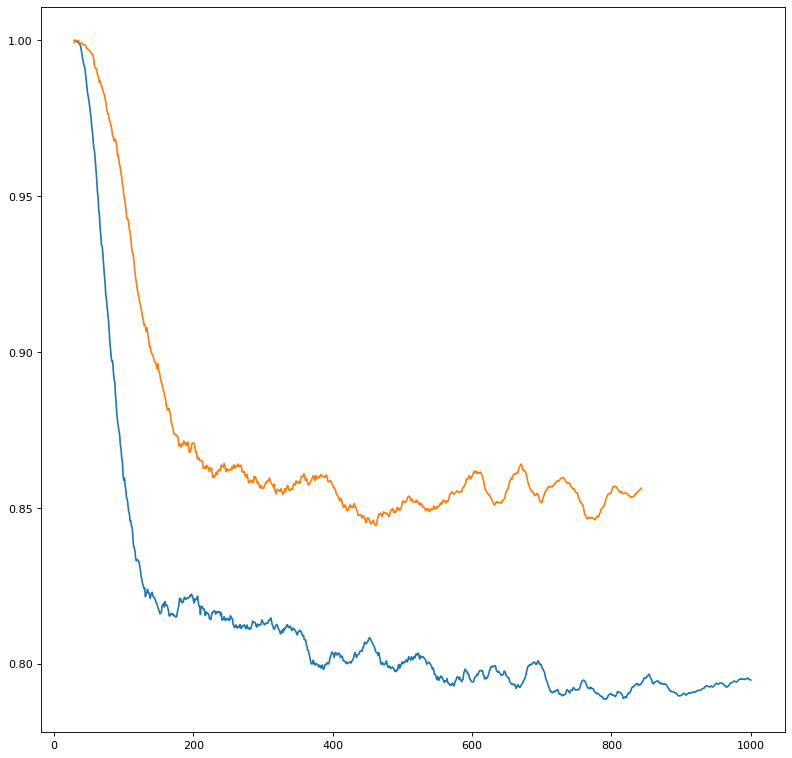

In [12]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt


figure(figsize=(12, 12), dpi=80)

for i in range(10):
    res[i][::2].reset_index()['val_wer'].rolling(30, win_type='gaussian').mean(std=100).plot(label=f'0.{i}')

plt.legend(loc="upper left")

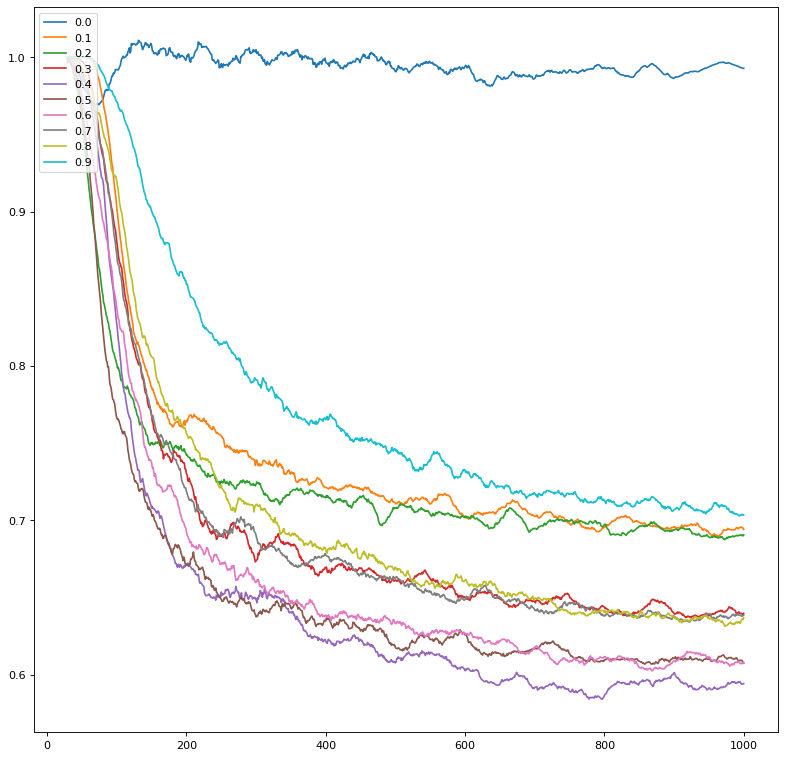

In [99]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt


figure(figsize=(12, 12), dpi=80)

for i in range(10):
    res[i][::2].reset_index()['val_wer'].rolling(30, win_type='gaussian').mean(std=100).plot(label=f'0.{i}')

plt.legend(loc="upper left")

In [60]:
res[i][::2].reset_index().rolling(window=10).sum()

,index,val_loss,val_wer,train_loss,learning_rate
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
996,19830.0,1534.086807,9.918499,4.798275,0.000020
997,19850.0,1533.346451,9.919793,5.835847,0.000016
998,19870.0,1532.077530,9.917206,6.153292,0.000013
999,19890.0,1530.368790,9.918499,6.779674,0.000010


In [106]:
first_asr_model.encoder.output_types

OrderedDict([('outputs',
              NeuralType(axis=(batch, dimension, time), element_type=AcousticEncodedRepresentation)),
             ('encoded_lengths',
              NeuralType(axis=(batch,), element_type=LengthsType))])

In [105]:
spec_gen.fastpitch.decoder.input_types

{'input': NeuralType(axis=(batch, time, dimension), element_type=EncodedRepresentation),
 'seq_lens': NeuralType(axis=(batch,), element_type=LengthsType),
 'conditioning': NeuralType(axis=(batch, time, dimension), element_type=EncodedRepresentation, optional=True)}

In [36]:
# --- Config Information ---#
try:
    from ruamel.yaml import YAML
except ModuleNotFoundError:
    from ruamel_yaml import YAML
config_path = './configs/quartznet_384_updated.yaml'

yaml = YAML(typ='safe')

In [11]:
train_manifest = './an4/train_manifest_200.json'
test_manifest = './an4/test_manifest.json'

In [12]:
with open(config_path) as f:
     params = yaml.load(f)

trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=1000)

params['model']['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = test_manifest
# params['model']['corruption_prob'] = float(corruption_prob)

first_asr_model = MyModel(cfg=DictConfig(params['model']), trainer=trainer)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


[NeMo I 2022-04-23 18:16:27 audio_to_text_dataset:41] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-04-23 18:16:27 audio_to_text_dataset:41] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-04-23 18:16:27 collections:183] Dataset loaded with 200 files totalling 0.16 hours
[NeMo I 2022-04-23 18:16:27 collections:184] 0 files were filtered totalling 0.00 hours
[NeMo I 2022-04-23 18:16:27 audio_to_text_dataset:41] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-04-23 18:16:27 audio_to_text_dataset:41] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-04-23 18:16:27 collections:183] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2022-04-23 18:16:27 collections:184] 0 files were filtered total

In [13]:
trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=20)
trainer.fit(first_asr_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[NeMo W 2022-04-23 13:32:35 modelPT:496] The lightning trainer received accelerator: <pytorch_lightning.accelerators.gpu.GPUAccelerator object at 0x7f2f528f0040>. We recommend to use 'ddp' instead.


[NeMo I 2022-04-23 13:32:35 modelPT:587] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        initial_lr: 0.01
        lr: 0.009999901304280686
        weight_decay: 0.001
    )
[NeMo I 2022-04-23 13:32:35 lr_scheduler:833] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f2f1051df70>" 
    will be used during training (effective maximum steps = 7000) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 7000
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 788 K 
2 | decoder           | ConvASRDecoder                    | 11.2 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
799 K     Trainable params
0         Non-trainable params
799 K     Total params
3.200     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-23 13:32:42 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
      rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
    


In [14]:
first_asr_model.cuda()
spec_gen.cuda()
pass

MyFastPitchModel(
  (mel_loss): MelLoss()
  (pitch_loss): PitchLoss()
  (duration_loss): DurationLoss()
  (aligner): AlignmentEncoder(
    (softmax): Softmax(dim=3)
    (log_softmax): LogSoftmax(dim=3)
    (key_proj): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(384, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ReLU()
      (2): ConvNorm(
        (conv): Conv1d(768, 80, kernel_size=(1,), stride=(1,))
      )
    )
    (query_proj): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(80, 160, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ReLU()
      (2): ConvNorm(
        (conv): Conv1d(160, 80, kernel_size=(1,), stride=(1,))
      )
      (3): ReLU()
      (4): ConvNorm(
        (conv): Conv1d(80, 80, kernel_size=(1,), stride=(1,))
      )
    )
  )
  (forward_sum_loss): ForwardSumLoss(
    (log_softmax): LogSoftmax(dim=3)
    (ctc_loss): CTCLoss()
  )
  (bin_loss): BinLoss()
  (preprocessor): AudioToMelSpectrogramPreprocessor(


In [82]:
for batch in first_asr_model.train_dataloader():

    _, _, _, _ = batch
    
#     log_probs, encoded_len, predictions = first_asr_model.forward(input_signal=signal.cuda(),
#                                                                   input_signal_length=signal_len.cuda())
    
#     wer = WER(vocabulary=first_asr_model.decoder.vocabulary, batch_dim_index=0, use_cer=False, ctc_decode=True)
#     hypotheses = wer.ctc_decoder_predictions_tensor(predictions)
    
#     transcript = []
#     transcript_len = []
#     for item in hypotheses:
#         parsed = spec_gen.parse(item)
#         transcript.append(parsed[0])
#         transcript_len.append(len(parsed))
        
#     transcript = torch.tensor(transcript)
# #     transcript_len = torch.tensor(transcript_len)
    
#     enc_out, enc_mask = spec_gen.fastpitch.encoder(input=transcript, conditioning=torch.zeros(1).cuda())
    
    break

[NeMo W 2022-04-23 18:50:52 my_model_fastpitch:202] parse() is meant to be called in eval mode.
[NeMo W 2022-04-23 18:50:52 my_model_fastpitch:202] parse() is meant to be called in eval mode.
[NeMo W 2022-04-23 18:50:52 my_model_fastpitch:202] parse() is meant to be called in eval mode.
[NeMo W 2022-04-23 18:50:52 my_model_fastpitch:202] parse() is meant to be called in eval mode.


TypeError: only integer tensors of a single element can be converted to an index

In [96]:
for batch in spec_gen.train_dataloader():
    print(batch)
    break

TypeError: 'NoneType' object is not iterable

In [103]:
spec_gen.cfg['train_ds']['dataset']['manifest_filepath'] = './an4/train_manifest_200.json'
spec_gen.cfg['validation_ds']['dataset']['manifest_filepath'] = './an4/test_manifest.json'

spec_gen.setup_training_data(spec_gen.cfg['train_ds'])

ImportError: Encountered error: `No module named 'nemo.collections.tts.torch.data.MixerTTSDataset'; 'nemo.collections.tts.torch.data' is not a package` when loading module 'nemo.collections.tts.torch.data.MixerTTSDataset'

In [84]:
torch.stack(transcript)

RuntimeError: stack expects each tensor to be equal size, but got [196] at entry 0 and [337] at entry 1

In [89]:
spec_gen

MyFastPitchModel(
  (mel_loss): MelLoss()
  (pitch_loss): PitchLoss()
  (duration_loss): DurationLoss()
  (aligner): AlignmentEncoder(
    (softmax): Softmax(dim=3)
    (log_softmax): LogSoftmax(dim=3)
    (key_proj): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(384, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ReLU()
      (2): ConvNorm(
        (conv): Conv1d(768, 80, kernel_size=(1,), stride=(1,))
      )
    )
    (query_proj): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(80, 160, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ReLU()
      (2): ConvNorm(
        (conv): Conv1d(160, 80, kernel_size=(1,), stride=(1,))
      )
      (3): ReLU()
      (4): ConvNorm(
        (conv): Conv1d(80, 80, kernel_size=(1,), stride=(1,))
      )
    )
  )
  (forward_sum_loss): ForwardSumLoss(
    (log_softmax): LogSoftmax(dim=3)
    (ctc_loss): CTCLoss()
  )
  (bin_loss): BinLoss()
  (preprocessor): AudioToMelSpectrogramPreprocessor(


In [24]:
spec_gen.parse('qwe')

[NeMo W 2022-04-23 18:33:03 my_model_fastpitch:202] parse() is meant to be called in eval mode.


tensor([[ 0, 86, 92, 74,  0]], device='cuda:0')

In [30]:
len(hypotheses[1])

174

In [55]:
spec_gen.parse(hypotheses).shape

[NeMo W 2022-04-23 18:43:38 my_model_fastpitch:202] parse() is meant to be called in eval mode.


torch.Size([1, 731])

In [58]:
hypotheses

["zlzldnizlnlqnirblngxrswipkhkzhlcliczckwernrlhnlexojpwotvarpzjnblzqcrczclilzlzfzhrjrvzezjrhplelhzczlhzbcxjhqrhnzdnozlhjiezhnizbclcik zchrjniljlhghnhus'nizn'khrzcncrnzsnjnrdnzhnhnhnhnzay",
 "ztlnilakninrnrfnrdlpanrilpligignbkjndalalnuh'aoernhnz'aukrnjfjienenenbjnbnhojzqxeuclintndnlkndopjtzirkzhrnrcjnchznicznzhizezbnbnlbkfewzwxreozjzrfgskgenwijnznxarnzenhnvinpnbny",
 "ciciclznirfricbfrgoiawnlotnjzlnhzngcgekwnhnalnhzcnznzleawrcehenkznlnpnkrhejohrh'jhnhohapzcjncnhbn'vanihu'uountkngcgzhnlnzsnirdzhbhianlhnlnkwznojlzlzflnkznzrnrpfnhnbnpblkrgzlnzrahfnfuhplfzy",
 "czhzhzbqehpnrnhnphnxngxzrltlfjnfnknvnvz'njznjhzjnknkhnpznznbn'hbnqdhjwchjahzlnlabrbrkofclhfhz'hlzbchzc'bcacphnhlncnchnjhfl'h'nhalhdrzlpcpcnafohvav'nvnzbpnhsncaqpclbfny"]

In [97]:
(batch[2] != 0).unsqueeze(2)

tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])

In [96]:
batch[2][0]

tensor([18, 21,  2, 15, 21, 20,  0,  3,  0, 25,  0, 18,  0,  2,  0, 19,  5, 22,
         5, 14,  0,  5,  9,  7,  8, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0])

In [53]:
encoded[0][0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0027,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0603, 0.0000, 0.0986, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0301, 0.0000, 0.0000, 0.0779, 0.0971, 0.1365, 0.0000, 0.0000, 0.0000,
        0.1403, 0.0000, 0.0000, 0.2094, 0.4717, 0.0843, 0.4944, 0.2940, 0.0769,
        0.2418, 0.2076, 0.1693, 0.1601, 0.0000, 0.2703, 0.2421, 0.2782, 0.5066,
        0.3154, 0.2142, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1081,
        0.0000, 0.0000, 0.0098, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0869, 0.0000, 0.0000, 0.0000, 0.0830, 0.0000, 0.0000, 0.0000, 0.2305,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1212, 0.3178,
        0.7219, 0.1745, 0.0000, 0.0284, 0.0000, 0.0000, 0.0879, 0.3023, 0.8780,
        0.7184, 0.4347, 0.2526, 0.3994, 0.3185, 0.0000, 0.2000, 0.3537, 0.2141,
        0.0000, 0.0000, 0.1664, 0.0000, 

In [73]:
for batch in spec_gen.train_dataloader():
    enc_out, enc_mask = spec_gen.fastpitch.encoder(input=batch[2].cuda(), conditioning=torch.zeros(1).cuda())

#     print(enc_out)
    
    log_probs = first_asr_model.decoder(encoder_output=enc_out.permute(0, 2, 1))
    
    greedy_predictions = log_probs.argmax(dim=-1, keepdim=False)

    print(log_probs, greedy_predictions)
    
    break

tensor([[[-4.3055, -1.8805, -3.4918,  ..., -3.0159, -4.6967, -2.4815],
         [-5.1603, -2.4164, -3.1590,  ..., -5.7968, -0.9857, -3.9541],
         [-6.1897, -2.8769, -4.2385,  ..., -3.2272, -2.8609, -4.2693],
         ...,
         [-3.3206, -3.3404, -3.3900,  ..., -3.3324, -3.3609, -3.3541],
         [-3.3206, -3.3404, -3.3900,  ..., -3.3324, -3.3609, -3.3541],
         [-3.3206, -3.3404, -3.3900,  ..., -3.3324, -3.3609, -3.3541]],

        [[-4.5594, -1.9606, -2.3378,  ..., -3.5869, -5.0904, -3.0410],
         [-6.4577, -2.9306, -4.1002,  ..., -5.7940, -3.1817, -2.5025],
         [-5.5370, -3.1751, -1.6689,  ..., -5.9970, -2.8801, -2.0179],
         ...,
         [-3.3206, -3.3404, -3.3900,  ..., -3.3324, -3.3609, -3.3541],
         [-3.3206, -3.3404, -3.3900,  ..., -3.3324, -3.3609, -3.3541],
         [-3.3206, -3.3404, -3.3900,  ..., -3.3324, -3.3609, -3.3541]],

        [[-4.3438, -1.7340, -3.5010,  ..., -4.6494, -5.1081, -3.8618],
         [-6.1571, -1.2449, -3.7514,  ..., -5

In [74]:
enc_mask.shape

torch.Size([10, 36, 1])

In [81]:
(batch[2] != spec_gen.fastpitch.encoder.padding_idx).unsqueeze(2)[1]

tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])

In [82]:
enc_mask

tensor([[[ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
        

In [24]:
encoded.shape

torch.Size([32, 384, 528])

In [44]:
batch[1].shape

torch.Size([10])

In [55]:
first_asr_model.encoder.output_types

OrderedDict([('outputs',
              NeuralType(axis=(batch, dimension, time), element_type=AcousticEncodedRepresentation)),
             ('encoded_lengths',
              NeuralType(axis=(batch,), element_type=LengthsType))])

In [54]:
spec_gen.fastpitch.encoder.output_types

{'out': NeuralType(axis=(batch, time, dimension), element_type=EncodedRepresentation),
 'mask': NeuralType(axis=(batch, time, dimension), element_type=MaskType)}

In [28]:
spec_gen.fastpitch.decoder.input_types

{'input': NeuralType(axis=(batch, time, dimension), element_type=EncodedRepresentation),
 'seq_lens': NeuralType(axis=(batch,), element_type=LengthsType),
 'conditioning': NeuralType(axis=(batch, time, dimension), element_type=EncodedRepresentation, optional=True)}

In [8]:
import torch

In [6]:
first_asr_model.cuda()

MyModel(
  (preprocessor): AudioToMelSpectrogramPreprocessor(
    (featurizer): FilterbankFeatures()
  )
  (encoder): ConvASREncoder(
    (encoder): Sequential(
      (0): JasperBlock(
        (mconv): ModuleList(
          (0): MaskedConv1d(
            (conv): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(5,), groups=64, bias=False)
          )
          (1): MaskedConv1d(
            (conv): Conv1d(64, 128, kernel_size=(1,), stride=(1,), bias=False)
          )
          (2): BatchNorm1d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (3): SqueezeExcite(
            (fc): Sequential(
              (0): Linear(in_features=128, out_features=16, bias=False)
              (1): ReLU(inplace=True)
              (2): Linear(in_features=16, out_features=128, bias=False)
            )
            (gap): AdaptiveAvgPool1d(output_size=1)
          )
        )
        (res): ModuleList(
          (0): ModuleList(
            (0): MaskedConv1d(
          

In [14]:
for batch in first_asr_model.train_dataloader():
    signal, signal_len, transcript, transcript_len = batch
    
    log_probs, encoded_len, predictions = first_asr_model.forward(input_signal=signal.cuda(),
                                                                  input_signal_length=signal_len.cuda())

    print(log_probs.shape, transcript.shape, encoded_len.shape, transcript_len.shape)
    
    log_probs = torch.vstack((log_probs, log_probs))
    transcript = torch.vstack((transcript, transcript))
    encoded_len = torch.hstack((encoded_len, encoded_len))
    transcript_len = torch.hstack((transcript_len, transcript_len))

    print(log_probs.shape, transcript.shape, encoded_len.shape, transcript_len.shape)
    
    loss_value = first_asr_model.loss(
        log_probs=log_probs, targets=transcript, input_lengths=encoded_len, target_lengths=transcript_len
    )
    
    print(loss_value)
    
    break

torch.Size([32, 560, 29]) torch.Size([32, 55]) torch.Size([32]) torch.Size([32])
torch.Size([64, 560, 29]) torch.Size([64, 55]) torch.Size([64]) torch.Size([64])
tensor(818.7930, device='cuda:0', grad_fn=<MeanBackward0>)


In [20]:
import torch

In [13]:
torch.hstack((encoded_len, encoded_len)).shape

torch.Size([64])

In [21]:
for batch in spec_gen.train_dataloader():
    enc_out, enc_mask = spec_gen.fastpitch.encoder(input=batch[2].cuda(), conditioning=torch.zeros(1).cuda())

#     print(enc_out)
    
#     log_probs = first_asr_model.decoder(encoder_output=enc_out.permute(0, 2, 1))
    
#     greedy_predictions = log_probs.argmax(dim=-1, keepdim=False)

#     print(log_probs, greedy_predictions)
    
    break

In [23]:
enc_out[0]

tensor([[-0.4732, -1.9963, -1.7532,  ...,  0.2844,  0.4391, -1.0895],
        [-0.0745,  0.6962, -1.9129,  ..., -1.5412, -1.2824, -0.9759],
        [-0.1909,  1.1918, -1.2338,  ..., -0.3695,  1.2455, -0.4405],
        ...,
        [ 0.0000,  0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000,  0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [25]:
from nemo.collections.asr.metrics.wer import WER


wer = WER(vocabulary=first_asr_model.decoder.vocabulary, batch_dim_index=0, use_cer=False, ctc_decode=True)
hypotheses = wer.ctc_decoder_predictions_tensor(greedy_predictions)

NameError: name 'greedy_predictions' is not defined

In [48]:
hypotheses

['frytajuarbaiarf ',
 "a'iy'fr'tbfafy'fbtryrt ",
 'avauaqaybairafof ',
 'fypapapfufbuaufyfryrgpaypapayw',
 "ry'waz'arubrfra ",
 "r'ya ",
 'rwrjfwrzfafafafkfytuoryzf ',
 "r'ify'ajztrtrfjifywt ",
 "fz'aiajzaif ",
 "tai'janaftafba "]

In [44]:
import torch

In [33]:
print(spec_gen.fastpitch.encoder.output_types, '\n')
print(first_asr_model.decoder.input_types)


{'out': NeuralType(axis=(batch, time, dimension), element_type=EncodedRepresentation), 'mask': NeuralType(axis=(batch, time, dimension), element_type=MaskType)} 

OrderedDict([('encoder_output', NeuralType(axis=(batch, dimension, time), element_type=AcousticEncodedRepresentation))])


In [29]:
len(encoded[0][0]), len(encoded[2][1])

(560, 560)

In [21]:
encoded_len

tensor([391,  71, 271,  91, 401, 231, 221, 181, 261,  91, 291, 411, 441, 431,
        221, 371, 131, 301, 161, 311, 181, 151, 551, 181, 151, 131,  91, 301,
        331, 241, 331, 421], device='cuda:0')

In [36]:
first_asr_model = otherModel.asr_model

In [37]:
# Bigger batch-size = bigger throughput
# params['model']['validation_ds']['batch_size'] = 16

# Setup the test data loader and make sure the model is on GPU
# first_asr_model.setup_test_data(test_data_config=params['model']['validation_ds'])
first_asr_model.cuda()
first_asr_model.eval()

# We will be computing Word Error Rate (WER) metric between our hypothesis and predictions.
# WER is computed as numerator/denominator.
# We'll gather all the test batches' numerators and denominators.
wer_nums = []
wer_denoms = []

# Loop over all test batches.
# Iterating over the model's `test_dataloader` will give us:
# (audio_signal, audio_signal_length, transcript_tokens, transcript_length)
# See the AudioToCharDataset for more details.
for test_batch in first_asr_model.val_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = first_asr_model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        # Notice the model has a helper object to compute WER
        first_asr_model._wer.update(greedy_predictions, targets, targets_lengths)
        _, wer_num, wer_denom = first_asr_model._wer.compute()
        first_asr_model._wer.reset()
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

        # Release tensors from GPU memory
        del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

WER = 0.7678820482167763


In [20]:
first_asr_model.cuda()
spec_gen.cuda()

MyFastPitchModel(
  (mel_loss): MelLoss()
  (pitch_loss): PitchLoss()
  (duration_loss): DurationLoss()
  (aligner): AlignmentEncoder(
    (softmax): Softmax(dim=3)
    (log_softmax): LogSoftmax(dim=3)
    (key_proj): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(384, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ReLU()
      (2): ConvNorm(
        (conv): Conv1d(768, 80, kernel_size=(1,), stride=(1,))
      )
    )
    (query_proj): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(80, 160, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ReLU()
      (2): ConvNorm(
        (conv): Conv1d(160, 80, kernel_size=(1,), stride=(1,))
      )
      (3): ReLU()
      (4): ConvNorm(
        (conv): Conv1d(80, 80, kernel_size=(1,), stride=(1,))
      )
    )
  )
  (forward_sum_loss): ForwardSumLoss(
    (log_softmax): LogSoftmax(dim=3)
    (ctc_loss): CTCLoss()
  )
  (bin_loss): BinLoss()
  (preprocessor): AudioToMelSpectrogramPreprocessor(


In [22]:
for batch in first_asr_model.train_dataloader():
    processed_signal, processed_signal_length = first_asr_model.preprocessor(
        input_signal=batch[0].cuda(), length=batch[1].cuda())
    
    encoded, encoded_len = first_asr_model.encoder(audio_signal=processed_signal, length=processed_signal_length)
    print(encoded, encoded_len)
    
    log_probs = first_asr_model.decoder(encoder_output=encoded)
    greedy_predictions = log_probs.argmax(dim=-1, keepdim=False)
    break

tensor([[[0.2002, 0.1675, 0.1684,  ..., 0.0000, 0.0000, 0.0000],
         [0.0391, 0.0676, 0.2832,  ..., 0.0000, 0.0000, 0.0000],
         [0.3094, 0.6549, 0.8826,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.2398, 0.2363, 0.3424,  ..., 0.0000, 0.0000, 0.0000],
         [0.1850, 0.1286, 0.4601,  ..., 0.0000, 0.0000, 0.0000],
         [0.2798, 0.0441, 0.4812,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1873, 0.1609, 0.1370,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.3052, 0.3720, 0.3902,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1977, 0.3020,  ..., 0.0000, 0.0000, 0.0000],
         [0.3333, 0.5004, 0.3596,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.2272, 0.2261, 0.3197,  ..., 0.0000, 0.0000, 0.0000],
         [0.2951, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.2702,  ..., 0.0000, 0.0000, 0.

In [2]:
from my_model_fastpitch import MyFastPitchModel

In [46]:
import os
from omegaconf import DictConfig

# --- Config Information ---#
try:
    from ruamel.yaml import YAML
except ModuleNotFoundError:
    from ruamel_yaml import YAML
config_path = './configs/config.yaml'

yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)

In [48]:
config_path = 'configs'
config_name = 'fastpitch_align.yaml'
yaml = YAML(typ='safe')

with open(os.path.join(config_path, config_name)) as f:
    config = yaml.load(f)

config['model']['train_ds']['manifest_filepath']=train_manifest
config['model']['validation_ds']['manifest_filepath']=test_manifest

# config['init_from_nemo_model'] = './tts_en_fastpitch_align.nemo'

spec_gen = MyFastPitchModel.from_config_dict(DictConfig(config['model']))

[NeMo E 2022-04-23 18:41:51 vocabs:324] Torch distributed needs to be initialized before you initialized <nemo.collections.common.data.vocabs.Phonemes object at 0x7fd421c100d0>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo E 2022-04-23 18:41:52 vocabs:324] Torch distributed needs to be initialized before you initialized <nemo.collections.common.data.vocabs.Phonemes object at 0x7fd41a824940>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.


[NeMo I 2022-04-23 18:41:54 collections:183] Dataset loaded with 200 files totalling 0.16 hours
[NeMo I 2022-04-23 18:41:54 collections:184] 0 files were filtered totalling 0.00 hours


[NeMo E 2022-04-23 18:41:55 vocabs:324] Torch distributed needs to be initialized before you initialized <nemo.collections.common.data.vocabs.Phonemes object at 0x7fd413541400>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.


[NeMo I 2022-04-23 18:41:55 collections:183] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2022-04-23 18:41:55 collections:184] 0 files were filtered totalling 0.00 hours
[NeMo I 2022-04-23 18:41:55 features:259] PADDING: 1
[NeMo I 2022-04-23 18:41:55 features:276] STFT using torch


In [4]:
import pytorch_lightning as pl
trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [18]:
# Start training!!!
trainer.fit(spec_gen)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[NeMo W 2022-04-23 13:35:33 modelPT:475] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2022-04-23 13:35:33 modelPT:587] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: [0.9, 0.98]
        eps: 1e-08
        foreach: None
        lr: 0.0002
        maximize: False
        weight_decay: 1e-06
    )
[NeMo I 2022-04-23 13:35:33 lr_scheduler:698] Scheduler not initialized as no `sched` config supplied to setup_optimizer()



  | Name             | Type                              | Params
-----------------------------------------------------------------------
0 | mel_loss         | MelLoss                           | 0     
1 | pitch_loss       | PitchLoss                         | 0     
2 | duration_loss    | DurationLoss                      | 0     
3 | aligner          | AlignmentEncoder                  | 1.0 M 
4 | forward_sum_loss | ForwardSumLoss                    | 0     
5 | bin_loss         | BinLoss                           | 0     
6 | preprocessor     | AudioToMelSpectrogramPreprocessor | 0     
7 | fastpitch        | MyFastPitchModule                 | 45.8 M
-----------------------------------------------------------------------
45.8 M    Trainable params
0         Non-trainable params
45.8 M    Total params
183.035   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2022-04-23 13:35:33 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
      rank_zero_warn(
    
[NeMo W 2022-04-23 13:35:36 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
      rank_zero_warn(
    


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-23 13:35:38 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/torch/nn/modules/module.py:1385: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
      warnings.warn(
    


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-23 13:35:48 nemo_logging:349] /media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
      rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
    


In [30]:
import random

In [34]:
for batch in spec_gen.train_dataloader():
    k = 0.3
    for i in range(batch[2].shape[0]):
        for j in range(batch[2].shape[1]):
            if random.random() < k:
                batch[2][i][j] = 0
                
    print(batch[2])
    enc_out, enc_mask = spec_gen.fastpitch.encoder(input=batch[2])
    print(enc_out)
    break

tensor([[ 0, 84, 83,  0,  0,  0, 15, 56,  0,  0,  0, 20, 31, 12,  0]])
tensor([[[-0.6192,  0.0753, -0.5459,  ..., -0.1944, -0.7629, -0.3462],
         [-0.8795, -1.1611,  0.8070,  ...,  1.1659,  1.0064, -0.3905],
         [ 1.5288, -0.6130,  1.9968,  ..., -0.5969, -0.7954, -0.5629],
         ...,
         [-0.6013, -1.5182,  0.7893,  ...,  0.7257,  0.4711, -0.6783],
         [ 0.4347, -1.7803,  0.4144,  ...,  0.9773,  1.2060,  0.0040],
         [ 0.6068,  0.0707, -0.7345,  ...,  0.5157, -0.6101, -1.1222]]],
       grad_fn=<MulBackward0>)


In [1]:
from nemo.collections.asr.models import EncDecCTCModel
from nemo.collections.tts.models import FastPitchModel

/media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)
################################################################################
### WARNING, path does not exist: KALDI_ROOT=media/boris/F/pykaldi/kaldi
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-04-24 18:13:41 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [2]:
import contextlib
from typing import Optional

import torch
from hydra.utils import instantiate
from omegaconf import DictConfig, open_dict
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import LoggerCollection, TensorBoardLogger

from nemo.collections.asr.data.audio_to_text import AudioToCharWithDursF0Dataset
from nemo.collections.common.parts.preprocessing import parsers
from nemo.collections.tts.helpers.helpers import plot_alignment_to_numpy, plot_spectrogram_to_numpy
from nemo.collections.tts.losses.aligner_loss import BinLoss, ForwardSumLoss
from nemo.collections.tts.losses.fastpitchloss import DurationLoss, MelLoss, PitchLoss
from nemo.collections.tts.models.base import SpectrogramGenerator
# from nemo.collections.tts.modules.fastpitch import \
from nemo.collections.tts.torch.tts_data_types import SpeakerID
from nemo.core.classes import Exportable
from nemo.core.classes.common import PretrainedModelInfo, typecheck
from nemo.core.neural_types.elements import (
    Index,
    LengthsType,
    MelSpectrogramType,
    ProbsType,
    RegressionValuesType,
    TokenDurationType,
    TokenIndex,
    TokenLogDurationType,
)
from nemo.core.neural_types.neural_type import NeuralType
from nemo.utils import logging, model_utils

from nemo.core.classes import ModelPT

import nemo
import nemo.collections.asr as nemo_asr
from my_model_quartznet import MyModel
import os
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import copy

In [3]:
import copy
import inspect
import os
import uuid
from abc import abstractmethod
from os import path
from pathlib import Path
from typing import Callable, Dict, List, Optional, Union

import hydra
import torch
from omegaconf import DictConfig, OmegaConf, open_dict
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.utilities import rank_zero_only

from nemo import package_info
from nemo.core import optim
from nemo.core.classes.common import Model
from nemo.core.connectors.save_restore_connector import SaveRestoreConnector
from nemo.core.optim import prepare_lr_scheduler
from nemo.utils import logging, model_utils
from nemo.utils.app_state import AppState
from nemo.utils.get_rank import is_global_rank_zero
from nemo.collections.tts.models import Tacotron2Model


In [19]:
def flip_batch(batch):
    new_batch = torch.clone(batch[0]), torch.clone(batch[1]), torch.clone(batch[2]), torch.clone(batch[3])
    for i in range(len(new_batch)):
        try:
            for j in range(len(new_batch[i])):
                new_batch[i][j] = torch.flip(new_batch[i][j], dims=[0])
        except Exception:
            pass
    return new_batch

In [147]:
Tacotron2Model.list_available_models()

[PretrainedModelInfo(
 	pretrained_model_name=tts_en_tacotron2,
 	description=This model is trained on LJSpeech sampled at 22050Hz, and can be used to generate female English voices with an American accent.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_tacotron2/versions/1.0.0/files/tts_en_tacotron2.nemo,
 	class_=<class 'nemo.collections.tts.models.tacotron2.Tacotron2Model'>
 )]

In [141]:
class OtherModel(ModelPT):
    
    def __init__(self, asr_cfg: DictConfig, tts_cfg: DictConfig, trainer: Trainer = None, *args, **kwargs):
        cfg = OmegaConf.structured({})
        super().__init__(cfg, trainer=kwargs.get('trainer', None))
        self.asr_model = EncDecCTCModel.from_config_dict(asr_cfg)
        self.spec_gen = Tacotron2Model.from_config_dict(tts_cfg)
        
        self._wer = []
        self._other_wer = []
        self.corruption_prob = 0.4
        
        self.asr_model.setup_optimization()
        self.spec_gen.setup_optimization()

    
        self._train_dl = self.asr_model._train_dl
        self._validation_dl = self.asr_model._validation_dl
        self._test_dl = self.asr_model._test_dl
        self._optimizer_param_groups = self.asr_model._optimizer_param_groups
        self._optimizer = self.asr_model._optimizer
        self._scheduler = self.asr_model._scheduler
    
    def train_dataloader(self):
#         dataset = OnesDataset(10000)
        return self.spec_gen.train_dataloader()

    def val_dataloader(self):
#         dataset = OnesDataset(10)
        return self.spec_gen.val_dataloader()

    def predict_dataloader(self):
#         dataset = OnesDataset(10)
        return self.spec_gen.predict_dataloader()

    def forward_asr(
        self, input_signal=None, input_signal_length=None, processed_signal=None, processed_signal_length=None,
            dae=False
    ):
        processed_signal, processed_signal_length = self.asr_model.preprocessor(
            input_signal=input_signal, length=input_signal_length,
        )

        ## batch size 16
            
        ## audio corruption marking 8-15 parts of paired data

        encoded, encoded_len = self.asr_model.encoder(audio_signal=processed_signal, length=processed_signal_length)
        
        log_probs = self.asr_model.decoder(encoder_output=encoded)
        greedy_predictions = log_probs.argmax(dim=-1, keepdim=False)

        return log_probs, encoded_len, greedy_predictions

    def forward_spec_gen(self, *, tokens, token_len, audio=None, audio_len=None, dae=False):
        
        if audio is not None and audio_len is not None:
            spec_target, spec_target_len = self.spec_gen.audio_to_melspec_precessor(audio, audio_len)
        token_embedding = self.spec_gen.text_embedding(tokens).transpose(1, 2)
        encoder_embedding = self.spec_gen.encoder(token_embedding=token_embedding, token_len=token_len)
        if self.spec_gen.training:
            spec_pred_dec, gate_pred, alignments = self.spec_gen.decoder(
                memory=encoder_embedding, decoder_inputs=spec_target, memory_lengths=token_len
            )
        else:
            spec_pred_dec, gate_pred, alignments, pred_length = self.spec_gen.decoder(
                memory=encoder_embedding, memory_lengths=token_len
            )
        spec_pred_postnet = self.spec_gen.postnet(mel_spec=spec_pred_dec)

        if not self.spec_gen.calculate_loss:
            return spec_pred_dec, spec_pred_postnet, gate_pred, alignments, pred_length
        return spec_pred_dec, spec_pred_postnet, gate_pred, spec_target, spec_target_len, alignments

    def forward_dt_spec_gen(self, *, signal, signal_len):
        processed_signal, processed_signal_length = self.asr_model.preprocessor(
            input_signal=signal, length=signal_len,
        )

        encoded, encoded_len = self.asr_model.encoder(audio_signal=processed_signal, length=processed_signal_length)

        spec_target, spec_target_len = self.spec_gen.audio_to_melspec_precessor(signal, signal_len)

        spec_pred_dec, gate_pred, alignments = self.spec_gen.decoder(
            memory=encoded.permute(0, 2, 1).cuda(), decoder_inputs=spec_target.cuda(),
                memory_lengths=(torch.ones(encoded.shape[0]) * encoded.shape[2]).long().cuda()
        )

        del signal, signal_len, processed_signal, processed_signal_length, encoded, encoded_len
        
        spec_pred_postnet = self.spec_gen.postnet(mel_spec=spec_pred_dec)

        if not self.spec_gen.calculate_loss:
            return spec_pred_dec, spec_pred_postnet, gate_pred, alignments, pred_length

        return spec_pred_dec, spec_pred_postnet, gate_pred, spec_target, spec_target_len, alignments
    
    def forward_dt_asr(self, *, tokens, token_len):
        token_embedding = self.spec_gen.text_embedding(tokens).transpose(1, 2)
        encoder_embedding = self.spec_gen.encoder(token_embedding=token_embedding, token_len=token_len).permute(0, 2, 1)

        encoded_len = []
        for i in range(encoder_embedding.shape[0]):
            pos = encoder_embedding.shape[2]
            for j in range(len(encoder_embedding[i][0])):
                if encoder_embedding[i][0][j] == 0:
                    pos = j
                    break
            encoded_len.append(pos)
        encoded_len = torch.tensor(encoded_len)

        log_probs = self.asr_model.decoder(encoder_output=encoder_embedding)
        greedy_predictions = log_probs.argmax(dim=-1, keepdim=False)
        
        del tokens, token_len, token_embedding, encoder_embedding
        
        return log_probs, encoded_len, greedy_predictions
    
    def validation_step_asr(self, batch, batch_idx, dataloader_idx=0):
        signal, signal_len, transcript, transcript_len = batch
        
        
        
        transcript = transcript * (transcript < 28)
        
        log_probs, encoded_len, predictions = self.forward_asr(input_signal=signal, input_signal_length=signal_len, dae=False)

        loss_value = self.asr_model.loss(
            log_probs=log_probs, targets=transcript, input_lengths=encoded_len, target_lengths=transcript_len
        )
        self.asr_model._wer.update(
            predictions=predictions, targets=transcript, target_lengths=transcript_len, predictions_lengths=encoded_len
        )
        wer, wer_num, wer_denom = self.asr_model._wer.compute()
        self.asr_model._wer.reset()
        return {
            'val_loss': loss_value,
            'val_wer_num': wer_num,
            'val_wer_denom': wer_denom,
            'val_wer': wer,
        }

    def training_step_asr(self, batch, batch_idx):

        signal, signal_len, transcript, transcript_len = batch
                                                  
        for i in range(signal.shape[0] // 2):
            for j in range(signal.shape[1]):
                if random.random() < self.corruption_prob:
                    signal[i][j] = 0
            
        transcript = transcript * (transcript < 28)
        
        log_probs, encoded_len, predictions = self.forward_asr(input_signal=signal, input_signal_length=signal_len)
        
        loss_value = self.asr_model.loss(
            log_probs=log_probs, targets=transcript, input_lengths=encoded_len, target_lengths=transcript_len
        )
        
        for raw_batch in self.spec_gen.val_dataloader():
            _, _, tokens, token_len = batch
            
            log_probs, encoded_len, predictions = self.forward_dt_asr(tokens=tokens, token_len=token_len)
        
            loss_value += self.asr_model.loss(
                log_probs=log_probs, targets=transcript, input_lengths=encoded_len, target_lengths=transcript_len
            )

            break
        
        flipped_batch = flip_batch(batch)
        
        flipped_signal, flipped_signal_len, flipped_transcript, flipped_transcript_len = flipped_batch
                                                  
        for i in range(flipped_signal.shape[0] // 2):
            for j in range(flipped_signal.shape[1]):
                if random.random() < self.corruption_prob:
                    flipped_signal[i][j] = 0
            
        flipped_transcript = flipped_transcript * (flipped_transcript < 28)
        
        log_probs, encoded_len, predictions = self.forward_asr(input_signal=flipped_signal,
                                                               input_signal_length=flipped_signal_len)
        
        loss_value += self.asr_model.loss(
            log_probs=log_probs, targets=flipped_transcript, input_lengths=encoded_len, target_lengths=flipped_transcript_len
        )
        
        tensorboard_logs = {'train_loss': loss_value, 'learning_rate': self.asr_model._optimizer.param_groups[0]['lr']}

        log_every_n_steps = 50

        if (batch_idx + 1) % log_every_n_steps == 0:
            self.asr_model._wer.update(
                predictions=predictions,
                targets=transcript,
                target_lengths=transcript_len,
                predictions_lengths=encoded_len,
            )
            wer, _, _ = self.asr_model._wer.compute()
            self.asr_model._wer.reset()
            tensorboard_logs.update({'training_batch_wer': wer})
            self._other_wer.append(wer)
            
        return {'loss': loss_value} #, 'log': tensorboard_logs}

    def validation_step_spec_gen(self, batch, batch_idx):
        audio, audio_len, tokens, token_len = batch
        spec_pred_dec, spec_pred_postnet, gate_pred, spec_target, spec_target_len, alignments = self.forward_spec_gen(
            audio=audio, audio_len=audio_len, tokens=tokens, token_len=token_len, dae=False
        )

        loss, gate_target = self.spec_gen.loss(
            spec_pred_dec=spec_pred_dec,
            spec_pred_postnet=spec_pred_postnet,
            gate_pred=gate_pred,
            spec_target=spec_target,
            spec_target_len=spec_target_len,
            pad_value=self.spec_gen.pad_value,
        )
        return {
            "val_loss": loss,
            "mel_target": spec_target,
            "mel_postnet": spec_pred_postnet,
            "gate": gate_pred,
            "gate_target": gate_target,
            "alignments": alignments,
        }
    
    def training_step_spec_gen(self, batch, batch_idx):
        audio, audio_len, _tokens, token_len = batch
        
        tokens = torch.clone(_tokens)
        
        for i in range(tokens.shape[0] // 2):
            for j in range(tokens.shape[1]):
                if random.random() < self.corruption_prob:
                    tokens[i][j] = 0
        
        spec_pred_dec, spec_pred_postnet, gate_pred, spec_target, spec_target_len, _ = self.forward_spec_gen(
            audio=audio, audio_len=audio_len, tokens=tokens, token_len=token_len
        )

        loss, _ = self.spec_gen.loss(
            spec_pred_dec=spec_pred_dec,
            spec_pred_postnet=spec_pred_postnet,
            gate_pred=gate_pred,
            spec_target=spec_target,
            spec_target_len=spec_target_len,
            pad_value=self.spec_gen.pad_value,
        )
        
        for raw_batch in self.spec_gen.val_dataloader():
            
            signal, signal_len, _, _ = raw_batch
            signal, signal_len = signal.cuda(), signal_len.cuda()
            
            spec_pred_dec, spec_pred_postnet, gate_pred, spec_target, spec_target_len, _ = \
                self.forward_dt_spec_gen(signal=signal, signal_len=signal_len)
                
            loss += self.spec_gen.loss(
                spec_pred_dec=spec_pred_dec,
                spec_pred_postnet=spec_pred_postnet,
                gate_pred=gate_pred,
                spec_target=spec_target,
                spec_target_len=spec_target_len,
                pad_value=self.spec_gen.pad_value,
            )[0]
                
                
            del raw_batch
                
            break
        
        flipped_batch = flip_batch(batch)
        
        flipped_audio, flipped_audio_len, flipped__tokens, flipped_token_len = flipped_batch
        
        flipped_tokens = torch.clone(flipped__tokens)
        
        for i in range(flipped_tokens.shape[0] // 2):
            for j in range(flipped_tokens.shape[1]):
                if random.random() < self.corruption_prob:
                    flipped_tokens[i][j] = 0
        
        spec_pred_dec, spec_pred_postnet, gate_pred, spec_target, spec_target_len, _ = self.forward_spec_gen(
            audio=flipped_audio, audio_len=flipped_audio_len, tokens=flipped_tokens, token_len=flipped_token_len
        )

        loss, _ = self.spec_gen.loss(
            spec_pred_dec=spec_pred_dec,
            spec_pred_postnet=spec_pred_postnet,
            gate_pred=gate_pred,
            spec_target=spec_target,
            spec_target_len=spec_target_len,
            pad_value=self.spec_gen.pad_value,
        )
                

#         output = {
#             'loss': loss,
#             'progress_bar': {'training_loss': loss},
#             'log': {'loss': loss},
#         }
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        val_asr = self.validation_step_asr(batch, batch_idx)
        val_spec_gen = self.validation_step_spec_gen(batch, batch_idx)
    
        return {k: val_asr.get(k, 0) + val_spec_gen.get(k, 0) for k in set(val_asr) | set(val_spec_gen)}
    
    def training_step(self, batch, batch_idx):
        training_asr = self.training_step_asr(batch, batch_idx)
        training_spec_gen = self.training_step_spec_gen(batch, batch_idx)
    
        return {k: training_asr.get(k, 0) + training_spec_gen.get(k, 0) for k in set(training_asr) | set(training_spec_gen)}
    
    def list_available_models(self):
        pass

    def setup_training_data(self):
        pass

    def setup_validation_data(self):
        pass

    def validation_epoch_end(self, loss):
        
        wer_nums = []
        wer_denoms = []
        
        for test_batch in self.asr_model.val_dataloader():
            test_batch = [x.cuda() for x in test_batch]
            targets = test_batch[2]
            targets_lengths = test_batch[3]        
            log_probs, encoded_len, greedy_predictions = self.asr_model(
                input_signal=test_batch[0], input_signal_length=test_batch[1]
            )
            # Notice the model has a helper object to compute WER
            self.asr_model._wer.update(greedy_predictions, targets, targets_lengths)
            _, wer_num, wer_denom = self.asr_model._wer.compute()
            self.asr_model._wer.reset()
            wer_nums.append(wer_num.detach().cpu().numpy())
            wer_denoms.append(wer_denom.detach().cpu().numpy())

            # Release tensors from GPU memory
            del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

        # We need to sum all numerators and denominators first. Then divide.
        print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")
        
        self._wer.append(sum(wer_nums)/sum(wer_denoms))
        
        return self.asr_model.validation_epoch_end(loss)

In [142]:

otherModel = OtherModel(asr_cfg=DictConfig(params['model']),
                        tts_cfg=DictConfig(config['model']),
                        trainer=trainer)


[NeMo E 2022-04-25 16:56:49 tacotron2:288] The train dataloader for Tacotron2Model() has shuffle set to False!!!


[NeMo I 2022-04-25 16:56:49 collections:183] Dataset loaded with 1200 files totalling 0.93 hours
[NeMo I 2022-04-25 16:56:49 collections:184] 0 files were filtered totalling 0.00 hours


[NeMo E 2022-04-25 16:56:49 tacotron2:290] The validation dataloader for Tacotron2Model() has shuffle set to True!!!


[NeMo I 2022-04-25 16:56:49 collections:183] Dataset loaded with 878 files totalling 0.65 hours
[NeMo I 2022-04-25 16:56:49 collections:184] 0 files were filtered totalling 0.00 hours
[NeMo I 2022-04-25 16:56:49 features:259] PADDING: 16
[NeMo I 2022-04-25 16:56:49 features:276] STFT using torch


[NeMo W 2022-04-25 16:56:49 modelPT:475] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2022-04-25 16:56:49 modelPT:587] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        eps: 1e-08
        foreach: None
        lr: 0.001
        maximize: False
        weight_decay: 1e-06
    )


[NeMo W 2022-04-25 16:56:49 lr_scheduler:816] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


In [143]:
trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=1000, check_val_every_n_epoch=1)

trainer.fit(otherModel)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


[NeMo I 2022-04-25 16:56:50 modelPT:454] No optimizer config provided, therefore no optimizer was created



  | Name     | Type           | Params
--------------------------------------------
0 | spec_gen | Tacotron2Model | 28.1 M
--------------------------------------------
28.1 M    Trainable params
0         Non-trainable params
28.1 M    Total params
112.533   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2022-04-25 16:56:51 tacotron2:341] Reached max decoder steps 1000.


Training: 0it [00:00, ?it/s]

In [84]:
otherModel._wer

[0.9868499701135685]

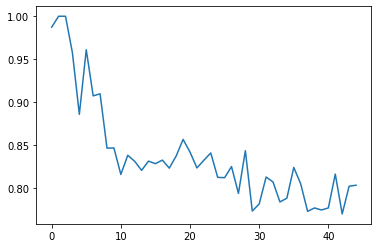

In [91]:
plt.plot(otherModel._wer)

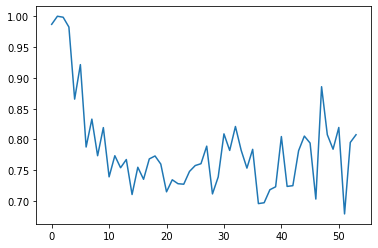

In [44]:
plt.plot(otherModel._wer)

In [32]:
import matplotlib.pyplot as plt

In [10]:
import random

In [144]:
# --- Config Information ---#
try:
    from ruamel.yaml import YAML
except ModuleNotFoundError:
    from ruamel_yaml import YAML
config_path = './configs/quartznet_384_updated.yaml'

yaml = YAML(typ='safe')

train_manifest = './an4/train_manifest_200.json'
test_manifest = './an4/test_manifest.json'

with open(config_path) as f:
     params = yaml.load(f)

# callback = PrintTableMetricsCallback()
trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=250, check_val_every_n_epoch=10)

params['model']['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = test_manifest
# params['model']['corruption_prob'] = float(corruption_prob)

config_path = 'configs'
config_name = 'tacotron2.yaml'

with open(os.path.join(config_path, config_name)) as f:
    config = yaml.load(f)

config['train_dataset']=train_manifest
config['validation_datasets']=test_manifest

# config['init_from_nemo_model'] = './tts_en_fastpitch_align.nemo'

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [136]:
asr_model = EncDecCTCModel.from_config_dict(DictConfig(params['model']))

[NeMo I 2022-04-24 18:03:32 audio_to_text_dataset:41] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-04-24 18:03:32 audio_to_text_dataset:41] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-04-24 18:03:32 collections:183] Dataset loaded with 1200 files totalling 0.93 hours
[NeMo I 2022-04-24 18:03:32 collections:184] 0 files were filtered totalling 0.00 hours
[NeMo I 2022-04-24 18:03:32 audio_to_text_dataset:41] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-04-24 18:03:32 audio_to_text_dataset:41] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-04-24 18:03:32 collections:183] Dataset loaded with 878 files totalling 0.65 hours
[NeMo I 2022-04-24 18:03:32 collections:184] 0 files were filtered tota

In [145]:
spec_gen = Tacotron2Model.from_config_dict(DictConfig(config['model']))


[NeMo E 2022-04-25 16:57:19 tacotron2:288] The train dataloader for Tacotron2Model() has shuffle set to False!!!


[NeMo I 2022-04-25 16:57:19 collections:183] Dataset loaded with 1200 files totalling 0.93 hours
[NeMo I 2022-04-25 16:57:19 collections:184] 0 files were filtered totalling 0.00 hours


[NeMo E 2022-04-25 16:57:19 tacotron2:290] The validation dataloader for Tacotron2Model() has shuffle set to True!!!


[NeMo I 2022-04-25 16:57:19 collections:183] Dataset loaded with 878 files totalling 0.65 hours
[NeMo I 2022-04-25 16:57:19 collections:184] 0 files were filtered totalling 0.00 hours
[NeMo I 2022-04-25 16:57:19 features:259] PADDING: 16
[NeMo I 2022-04-25 16:57:19 features:276] STFT using torch


In [146]:
trainer.fit(spec_gen)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
[NeMo W 2022-04-25 16:57:20 modelPT:475] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2022-04-25 16:57:20 modelPT:587] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        eps: 1e-08
        foreach: None
        lr: 0.001
        maximize: False
        weight_decay: 1e-06
    )


[NeMo W 2022-04-25 16:57:20 lr_scheduler:816] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !

  | Name                       | Type               | Params
------------------------------------------------------------------
0 | audio_to_melspec_precessor | FilterbankFeatures | 0     
1 | text_embedding             | Embedding          | 15.9 K
2 | encoder                    | Encoder            | 5.5 M 
3 | decoder                    | Decoder            | 18.3 M
4 | postnet                    | Postnet            | 4.3 M 
5 | loss                       | Tacotron2Loss      | 0     
------------------------------------------------------------------
28.1 M    Trainable params
0         Non-trainable params
28.1 M    Total params
112.533   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2022-04-25 16:57:21 tacotron2:341] Reached max decoder steps 1000.


Training: 0it [00:00, ?it/s]

In [7]:
asr_model.cuda()
spec_gen.cuda()

Tacotron2Model(
  (audio_to_melspec_precessor): FilterbankFeatures()
  (text_embedding): Embedding(31, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
     

In [147]:
def flip_batch(batch):
    new_batch = torch.clone(batch[0]), torch.clone(batch[1]), torch.clone(batch[2]), torch.clone(batch[3])
    for i in range(len(new_batch)):
        try:
            for j in range(len(new_batch[i])):
                new_batch[i][j] = torch.flip(new_batch[i][j], dims=[0])
        except Exception:
            pass
    return new_batch

In [148]:
for batch in asr_model.val_dataloader():
    print(batch[2][0], flip_batch(batch)[2][0])
    break

tensor([18, 21,  2, 15, 21, 20,  0, 10,  0,  2,  0, 24,  0, 18,  0, 26,  0, 14,
         9, 14,  5,  0, 20, 23,  5, 14, 20, 25]) tensor([25, 20, 14,  5, 23, 20,  0,  5, 14,  9, 14,  0, 26,  0, 18,  0, 24,  0,
         2,  0, 10,  0, 20, 21, 15,  2, 21, 18])


In [144]:
torch.clone(batch[0])

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.9602e-03,
         -2.9602e-03, -2.4719e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  6.1035e-05,
          6.1035e-05,  1.2207e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.4954e-03,
          1.1292e-03,  9.4604e-04],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.0376e-03,
          1.4648e-03,  7.9346e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  3.9673e-04,
          1.5259e-04,  2.1362e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.8311e-04,
         -1.8311e-04, -1.8311e-04]])

In [25]:
spec_pred_dec.shape, spec_pred_postnet.shape, gate_pred.shape, spec_target.shape, spec_target_len.shape, alignments.shape

(torch.Size([4, 80, 304]),
 torch.Size([4, 80, 304]),
 torch.Size([4, 304]),
 torch.Size([4, 80, 304]),
 torch.Size([4]),
 torch.Size([4, 304, 480]))

In [26]:
for batch in spec_gen.val_dataloader():
    audio, audio_len, tokens, token_len = batch
    spec_pred_dec, spec_pred_postnet, gate_pred, spec_target, spec_target_len, _ = spec_gen.forward(
            audio=audio, audio_len=audio_len, tokens=tokens, token_len=token_len
        )
    
    break

In [34]:
for batch in asr_model.train_dataloader():
    input_signal, input_signal_length, _
    
    processed_signal, processed_signal_length = asr_model.preprocessor(
        input_signal=input_signal, length=input_signal_length,
    )

    encoded, encoded_len = asr_model.encoder(audio_signal=processed_signal, length=processed_signal_length)
   
    log_probs = asr_model.decoder(encoder_output=encoded)
    greedy_predictions = log_probs.argmax(dim=-1, keepdim=False)
    
    break

In [71]:
raw_batch

(tensor([[ 9.7656e-04,  1.0986e-03,  1.0376e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-6.1035e-05,  6.1035e-05,  6.1035e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 3.0518e-04,  1.8311e-04,  2.4414e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-4.2725e-04, -2.4414e-04, -2.4414e-04,  ...,  1.2207e-04,
           3.0518e-04,  3.6621e-04]]),
 tensor([38400, 38400, 25600, 46400]),
 tensor([[28, 15, 14,  5,  0,  6,  9, 22,  5,  0, 20, 23, 15,  0, 15, 14,  5,  0,
          20,  8, 18,  5,  5, 29, 30],
         [28,  5, 14, 20,  5, 18,  0,  6,  9,  6, 20, 25,  0, 19,  9, 24, 20, 25,
           0, 20,  8, 18,  5,  5, 29],
         [28,  5, 14, 20,  5, 18,  0, 19,  9, 24, 20, 25,  0, 15, 14,  5, 29, 30,
          30, 30, 30, 30, 30, 30, 30],
         [28, 25,  0,  4,  0, 14,  0,  5,  0,  4,  0,  6, 15, 18, 20, 25,  0, 19,
           5, 22,  5, 14, 29, 30, 30]]),
 tensor([24, 25, 17, 23]))

In [101]:
# for raw_batch in spec_gen.val_dataloader():
_, _, tokens, token_len = raw_batch

token_embedding = spec_gen.text_embedding(tokens).transpose(1, 2)
encoder_embedding = spec_gen.encoder(token_embedding=token_embedding, token_len=token_len).permute(0, 2, 1)

encoded_len = []
for i in range(encoder_embedding.shape[0]):
    pos = encoder_embedding.shape[2]
    for j in range(len(encoder_embedding[i][0])):
        if encoder_embedding[i][0][j] == 0:
            pos = j
            break
    encoded_len.append(pos)
encoded_len = torch.tensor(encoded_len)

log_probs = asr_model.decoder(encoder_output=encoder_embedding)
greedy_predictions = log_probs.argmax(dim=-1, keepdim=False)

#     break

In [102]:
encoded_len

tensor([24, 25, 17, 23])

In [99]:
encoded_len = []
for i in range(encoder_embedding.shape[0]):
    pos = encoder_embedding.shape[2]
    for j in range(len(encoder_embedding[i][0])):
        if encoder_embedding[i][0][j] == 0:
            pos = j
            break
    print(pos)
    encoded_len.append(pos)
encoded_len = torch.tensor(encoded_len)
    
encoded_len

24
25
17
23


tensor([24, 25, 17, 23])

In [91]:
encoded_len

tensor([341,  91, 311, 291])

In [62]:
encoder_embedding.permute(0, 2, 1)[0]

tensor([[ 0.0641,  0.0299,  0.0199,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1409, -0.2770, -0.0487,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0252, -0.2691, -0.3036,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.1198,  0.1135,  0.2651,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1439,  0.3850,  0.1802,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2523,  0.0048, -0.0129,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<SelectBackward0>)

In [60]:
greedy_predictions

tensor([[22, 16,  1,  7,  2,  7, 19, 16, 17, 11, 24, 10, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [24, 13, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [22, 17, 24, 16, 24, 16,  7,  0,  7,  7, 16, 16, 16, 16, 16, 16, 16,  8,
          7, 22,  3,  5, 16,  3, 19, 16, 16,  5, 21, 15],
        [ 8,  5,  5,  5,  8,  5, 17, 28,  7, 17, 16, 17,  2, 24, 24, 24,  7, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]])

In [41]:
encoded_len

tensor([341,  91, 311, 291])

In [27]:
spec_pred_dec.shape, spec_pred_postnet.shape, gate_pred.shape, spec_target.shape, spec_target_len.shape, alignments.shape

(torch.Size([4, 80, 208]),
 torch.Size([4, 80, 208]),
 torch.Size([4, 208]),
 torch.Size([4, 80, 208]),
 torch.Size([4]),
 torch.Size([4, 304, 480]))

In [20]:
spec_pred_dec.shape

torch.Size([4, 80, 224])

In [ ]:
for batch in spec_gen.val_dataloader():
    signal, signal_len, _, _ = batch
    
    processed_signal, processed_signal_length = asr_model.preprocessor(
        input_signal=signal, length=signal_len,
    )

    encoded, encoded_len = asr_model.encoder(audio_signal=processed_signal, length=processed_signal_length)
      
    spec_target, spec_target_len = spec_gen.audio_to_melspec_precessor(signal, signal_len)
#         token_embedding = self.spec_gen.text_embedding(tokens).transpose(1, 2)
#         encoder_embedding = self.spec_gen.encoder(token_embedding=token_embedding, token_len=token_len)
    spec_pred_dec, gate_pred, alignments = spec_gen.decoder(
        memory=encoded.permute(0, 2, 1), decoder_inputs=spec_target,
            memory_lengths=(torch.ones(encoded.shape[0]) * encoded.shape[2]).long()
    )
    
    spec_pred_postnet = spec_gen.postnet(mel_spec=spec_pred_dec)

#     if not self.spec_gen.calculate_loss:
#         return spec_pred_dec, spec_pred_postnet, gate_pred, alignments, pred_length

#     return spec_pred_dec, spec_pred_postnet, gate_pred, spec_target, spec_target_len, alignments
    
    
    break

In [32]:
for batch in spec_gen.val_dataloader():
    _, _, tokens, token_len = batch
    
    token_embedding = spec_gen.text_embedding(tokens).transpose(1, 2)
    encoder_embedding = spec_gen.encoder(token_embedding=token_embedding, token_len=token_len)
    
    log_probs = asr_model.decoder(encoder_output=encoder_embedding.permute(0, 2, 1))
    greedy_predictions = log_probs.argmax(dim=-1, keepdim=False)
    
    break
    

NameError: name 'spec_gen' is not defined

In [32]:
greedy_predictions

tensor([[16, 19, 21, 21, 17, 27,  1, 12, 19, 19, 18,  3, 21, 21, 21, 21,  1, 18,
         18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
         18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
        [21, 17, 21, 21, 19, 21, 21, 21, 15, 21, 15,  0,  1, 11, 10, 18, 18, 18,
         18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
         18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
        [21, 18, 22, 21, 14,  3,  3,  9,  9,  0, 19, 19, 22, 22, 14, 22, 11, 24,
         11, 11,  1, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
         18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
        [21,  9, 21, 21, 10, 21, 17, 14, 21,  9, 21, 19, 21, 21, 22, 22, 22, 22,
         22, 22, 21, 19, 19, 19, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
         18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
        [21, 18, 11, 16, 11, 19,  9, 21,  1, 15, 19,  9, 21, 21, 21, 22, 22,  9,
         24, 27,  9, 27, 28, 19, 19, 22, 21, 21, 19, 19, 19, 10, 24,  7

In [23]:
encoded.shape

torch.Size([16, 512, 608])

In [28]:
asr_model.decoder.input_types

OrderedDict([('encoder_output',
              NeuralType(axis=(batch, dimension, time), element_type=AcousticEncodedRepresentation))])

In [27]:
spec_gen.encoder.output_types

{'encoder_embedding': NeuralType(axis=(batch, time, dimension), element_type=EmbeddedTextType)}

In [35]:
import random

In [150]:
trainer.fit(otherModel)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2022-04-24 07:40:00 modelPT:454] No optimizer config provided, therefore no optimizer was created



  | Name      | Type           | Params
---------------------------------------------
0 | asr_model | EncDecCTCModel | 799 K 
1 | spec_gen  | Tacotron2Model | 28.1 M
2 | vocoder   | TwoStagesModel | 0     
---------------------------------------------
28.9 M    Trainable params
0         Non-trainable params
28.9 M    Total params
115.733   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:40:09 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:09 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:10 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:11 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:12 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:13 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:13 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:14 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9676584734799483


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:40:23 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:24 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:25 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:25 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:26 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:27 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:28 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:28 tacotron2:341] Reached max decoder steps 1000.


WER = 1.0


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:40:38 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:38 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:39 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:40 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:41 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:41 tacotron2:341] Reached max decoder steps 1000.


WER = 1.0


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:40:51 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:52 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:52 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:40:53 tacotron2:341] Reached max decoder steps 1000.


WER = 1.0


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:41:03 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:03 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:04 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:05 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:06 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:06 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:07 tacotron2:341] Reached max decoder steps 1000.


WER = 1.0


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:41:17 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:18 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:18 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:19 tacotron2:341] Reached max decoder steps 1000.


WER = 1.0


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:41:28 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:29 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:30 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:31 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:32 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:32 tacotron2:341] Reached max decoder steps 1000.


WER = 1.0


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:41:42 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:43 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:44 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:44 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:45 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:46 tacotron2:341] Reached max decoder steps 1000.


WER = 1.0


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:41:55 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:57 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:41:58 tacotron2:341] Reached max decoder steps 1000.


WER = 1.0


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:42:08 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:42:09 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:42:10 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:42:10 tacotron2:341] Reached max decoder steps 1000.


WER = 1.0


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:42:20 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:42:20 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:42:21 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:42:22 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:42:23 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:42:24 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:42:25 tacotron2:341] Reached max decoder steps 1000.


WER = 1.0


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:42:34 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:42:35 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:42:36 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:42:37 tacotron2:341] Reached max decoder steps 1000.


WER = 1.0


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:42:46 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:42:47 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:42:48 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:42:48 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:42:49 tacotron2:341] Reached max decoder steps 1000.


WER = 1.0


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:42:59 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:43:00 tacotron2:341] Reached max decoder steps 1000.


WER = 1.0


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:43:09 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:43:10 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9961190168175937


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:43:20 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:43:21 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9987063389391979


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:43:30 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:43:31 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:43:32 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:43:33 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9715394566623544


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:43:42 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:43:43 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:43:44 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:43:44 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9805950840879689


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:43:54 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:43:55 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:43:56 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:43:57 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9676584734799483


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:44:07 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:08 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:08 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9883570504527813


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:44:18 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:19 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:20 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:21 tacotron2:341] Reached max decoder steps 1000.


WER = 1.0


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:44:31 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:31 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:32 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:33 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9676584734799483


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:44:43 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:43 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:44 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:45 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:46 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9805950840879689


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:44:55 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:56 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:56 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:57 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:58 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:59 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:44:59 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:00 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9857697283311773


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:45:09 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:10 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:11 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:12 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:13 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:14 tacotron2:341] Reached max decoder steps 1000.


WER = 1.0064683053040104


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:45:23 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:25 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:26 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9676584734799483


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:45:35 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:36 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:36 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:37 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:38 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:39 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:40 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9754204398447607


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:45:49 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:50 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:51 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:45:52 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9805950840879689


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:46:01 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:02 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:03 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:03 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:04 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:05 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:06 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:06 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9702457956015524


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:46:16 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:17 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:18 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9948253557567918


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:46:27 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:28 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:29 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:29 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:30 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:31 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9780077619663649


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:46:40 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:41 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:42 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:42 tacotron2:341] Reached max decoder steps 1000.


WER = 1.0517464424320828


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:46:52 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:53 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:54 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:46:54 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9767141009055628


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:47:04 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:05 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:05 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:06 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:07 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9935316946959897


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:47:16 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:17 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9805950840879689


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:47:27 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:28 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:29 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:30 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:31 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9728331177231565


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:47:40 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:41 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:42 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:42 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:43 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:44 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:45 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:45 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9793014230271668


Validating: 0it [00:00, ?it/s]

[NeMo W 2022-04-24 07:47:55 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:55 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:56 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:57 tacotron2:341] Reached max decoder steps 1000.
[NeMo W 2022-04-24 07:47:58 tacotron2:341] Reached max decoder steps 1000.


WER = 0.9870633893919794


In [151]:
for batch in spec_gen.val_dataloader():
    spectrograms = spec_gen.generate_spectrogram(tokens=batch[2].cuda())
    break

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper__index_select)

In [38]:
# from nemo.collections.tts.models import HifiGanModel

# vocoder = HifiGanModel.from_pretrained("tts_hifigan")

from nemo.collections.tts.models import TwoStagesModel
cfg = {'linvocoder':  {'_target_': 'nemo.collections.tts.models.two_stages.GriffinLimModel',
                     'cfg': {'n_iters': 64, 'n_fft': 1024, 'l_hop': 256}},
       'mel2spec': {'_target_': 'nemo.collections.tts.models.two_stages.MelPsuedoInverseModel',
                   'cfg': {'sampling_rate': 22050, 'n_fft': 1024, 
                           'mel_fmin': 0, 'mel_fmax': 8000, 'mel_freq': 80}}}
vocoder = TwoStagesModel(cfg)            
TwoStagesModel = True

In [128]:
# spec_gen = Tacotron2Model.from_pretrained("tts_en_tacotron2")
spec_gen = otherModel.spec_gen

In [129]:
vocoder.cuda()

TwoStagesModel(
  (mel2spec): MelPsuedoInverseModel()
  (linvocoder): GriffinLimModel()
)

In [130]:


def infer(spec_gen_model, vocoder_model, str_input, speaker = None):
    """
    Synthesizes spectrogram and audio from a text string given a spectrogram synthesis and vocoder model.
    
    Arguments:
    spec_gen_model -- Instance of FastPitch model
    vocoder_model -- Instance of a vocoder model (HiFiGAN in our case)
    str_input -- Text input for the synthesis
    speaker -- Speaker number (in the case of a multi-speaker model -- in the mixing case)
    
    Returns:
    spectrogram, waveform of the synthesized audio.
    """
    parser_model = spec_gen_model
    with torch.no_grad():
        parsed = parser_model.parse(str_input)
#         print(parsed)
        if speaker is not None:
            speaker = torch.tensor([speaker]).long().cuda()
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

spectrogram, audio = infer(spec_gen.cuda(), vocoder, "rubout g m e f three nine")

[NeMo W 2022-04-25 15:11:44 tacotron2:341] Reached max decoder steps 1000.


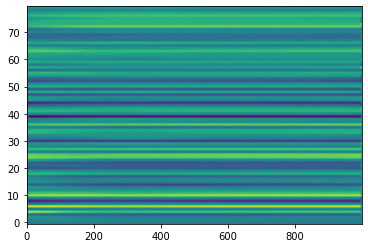

In [131]:
from matplotlib.pyplot import imshow

imshow(spectrogram, origin="lower", aspect = "auto")


In [57]:
import IPython.display as ipd

ipd.display(ipd.Audio(audio, rate=16000))

In [72]:
target = asr_model._wer.ctc_decoder_predictions_tensor(
        torch.tensor([[1, 2, 3, 4], [2, 3, 4, 5]]), predictions_len=torch.tensor([[4], [4]]), return_hypotheses=False,
    )

In [73]:
target

['abcd', 'bcde']

In [75]:
asr_model

EncDecCTCModel(
  (preprocessor): AudioToMelSpectrogramPreprocessor(
    (featurizer): FilterbankFeatures()
  )
  (encoder): ConvASREncoder(
    (encoder): Sequential(
      (0): JasperBlock(
        (mconv): ModuleList(
          (0): MaskedConv1d(
            (conv): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(5,), groups=64, bias=False)
          )
          (1): MaskedConv1d(
            (conv): Conv1d(64, 128, kernel_size=(1,), stride=(1,), bias=False)
          )
          (2): BatchNorm1d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (3): SqueezeExcite(
            (fc): Sequential(
              (0): Linear(in_features=128, out_features=16, bias=False)
              (1): ReLU(inplace=True)
              (2): Linear(in_features=16, out_features=128, bias=False)
            )
            (gap): AdaptiveAvgPool1d(output_size=1)
          )
        )
        (res): ModuleList(
          (0): ModuleList(
            (0): MaskedConv1d(
   

In [22]:
for batch in spec_gen.train_dataloader():
    print(batch[2][0])
    print(batch[2][0] * (batch[2][0] < 28))
    break

tensor([28,  3,  0, 15,  0, 14,  0, 14,  0,  5,  0, 12,  0, 12,  0, 25, 29, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30])
tensor([ 0,  3,  0, 15,  0, 14,  0, 14,  0,  5,  0, 12,  0, 12,  0, 25,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0])
